In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

(998, 998, 3)


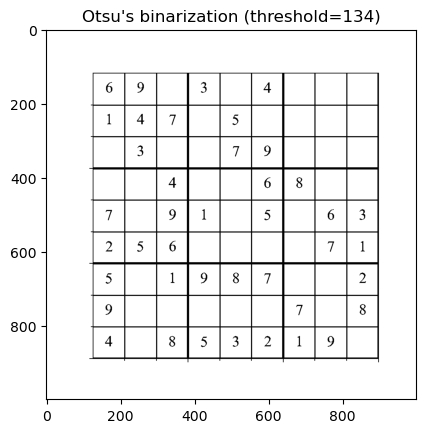

In [2]:
file="level2/sudoku_00030"
file="level1/sudoku_029"
# file="level2/sample"
image = cv2.imread(f"./data/{file}.jpg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
trim_percentage=0.001
height, width, channels = image.shape[:3]
trim_width = int(width * trim_percentage)
trim_height = int(height * trim_percentage)
image = image[trim_height:height - trim_height, trim_width:width - trim_width]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
print(image.shape)
# ぼかし処理
# gray_gb = cv2.GaussianBlur(gray, None, 4.0)
gray_gb= cv2.bilateralFilter(gray, 11, 5, 5)
# # median filter
# gray_gb = cv2.medianBlur(gray, 3)

# 大津の二値化
thr, binary = cv2.threshold(gray_gb, 0, 255, cv2.THRESH_OTSU)
new_thr = min(int(thr * 1.22), 255)
_, binary = cv2.threshold(gray_gb, new_thr, 255, cv2.THRESH_BINARY)
plt.imshow(binary, cmap="gray")
plt.title("Otsu's binarization (threshold={:d})".format(int(thr)))
plt.show()

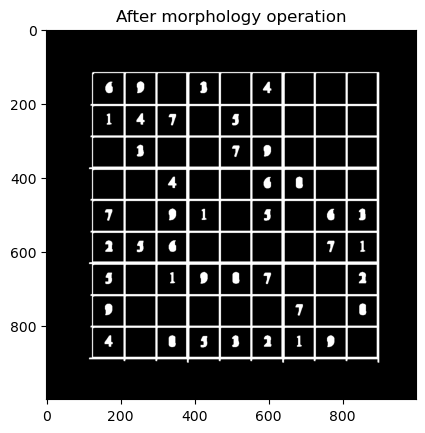

In [3]:
edge = cv2.Canny(binary, 100, 200)
edge = cv2.dilate(edge, np.ones((11, 11), dtype=edge.dtype),iterations=1)
edge = cv2.erode(edge, np.ones((9, 9), dtype=edge.dtype),iterations=1)
# res_close = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((5, 5), dtype=binary.dtype))
plt.imshow(edge, cmap="gray")
plt.title("After morphology operation".format(thr))
plt.show()

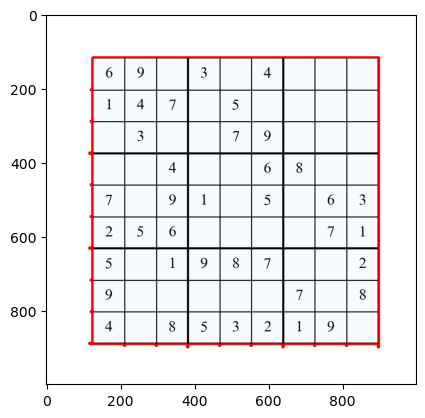

In [4]:
contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
result = image.copy()
cv2.drawContours(result, contours, -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.show()

4 116 116 783 784 3269.10 0.98 599513.5
126


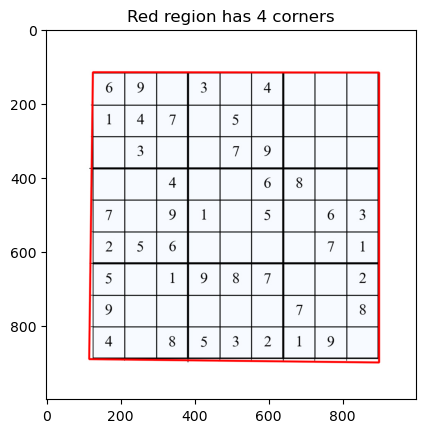

In [5]:
longest_cnt = None
max_length = 0.0
max_area = 0.0
result = image.copy()
for cnt in contours:
    # 輪郭線の長さを計算
    arclen = cv2.arcLength(cnt, True)
    approx=cv2.approxPolyDP(cnt, arclen * 5e-2, True)
    area=cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(approx)
    internal_area_ratio = area / (w * h)
    if len(approx) == 4 and internal_area_ratio>0.5:
        print(len(approx), x,y,w,h,"{:.2f}".format(arclen),"{:.2f}".format(internal_area_ratio),area)
        cv2.drawContours(result, [approx], -1, (255, 0, 0), 3, cv2.LINE_AA)
        # plt.imshow(result)
        # plt.show()
        if  max_area < area:
            max_area = area
            max_length = arclen
            longest_cnt = cnt
                
result = image.copy()

# plt.imshow(result)
# plt.show()
print(len(longest_cnt))
arclen = cv2.arcLength(longest_cnt, True)
approx = cv2.approxPolyDP(longest_cnt, arclen * 5e-2, True)

cv2.drawContours(result, [approx], -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.title("Red region has {:d} corners".format(len(approx)))
plt.show()
# len(contours[0])

[[[126 116]]

 [[116 890]]

 [[898 899]]

 [[898 117]]]
[[126. 116.]
 [898. 117.]
 [898. 899.]
 [116. 890.]]
(1000, 1000, 3)


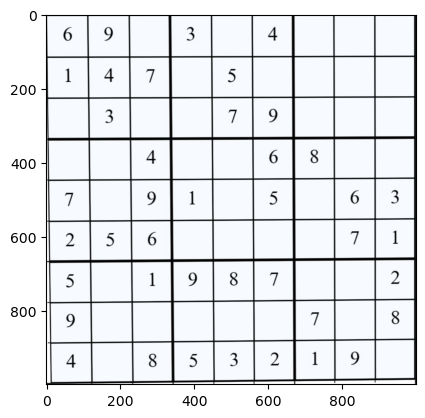

In [6]:
from sklearn.preprocessing import StandardScaler
x, y, w, h = cv2.boundingRect(approx)
cropped = image[y:y+h, x:x+w]

# plt.imshow(cropped)
# plt.show()
print(approx)
# approx=approx-(x,y)
# print(approx)

src_pts = approx.reshape((-1, 2)).astype("float32")
center = np.mean(src_pts, axis=0)

# ４点を重心からの角度でソートする
# 時計回りになる
src_pts = np.array(sorted(src_pts, key=lambda p: np.arctan2(p[1]-center[1], p[0]-center[0])))

# 結果を表示する
print(src_pts)

# src_pts = np.array([approx[0], approx[1], approx[2], approx[3]], dtype="float32")
# print(src_pts)
# 縦横比の計算
w = np.linalg.norm(src_pts[3] - src_pts[0])
h = np.linalg.norm(src_pts[1] - src_pts[0])
aspect = abs(w) / abs(h)

# 新しい画像サイズを設定
new_w = int(1000*aspect)
# new_w = 1000
new_h = 1000
# dst_pts = np.array([(0, 0), (0, new_h), (new_w, new_h), (new_w, 0)], dtype="float32")
dst_pts = np.array([(0, 0), (new_w, 0), (new_w, new_h), (0, new_h)], dtype="float32")

# 射影変換を計算して、パースをキャンセルする
warp = cv2.getPerspectiveTransform(src_pts, dst_pts)
result = cv2.warpPerspective(image, warp, (new_w, new_h))
result=cv2.resize(result,(1000,1000),interpolation=cv2.INTER_AREA)
print(result.shape)
# result = cv2.warpPerspective(binary, warp, (new_w, new_h))

#　反転させたリストを作成

# for i, result in enumerate(results):

    # plt.subplot(2, 2, i+1)
    # plt.imshow(result)
    # plt.title("result {:d}".format(i))

plt.imshow(result, cmap="gray")
plt.show()

(1000, 1000, 3)
(254.0, 254.0, 255.0)


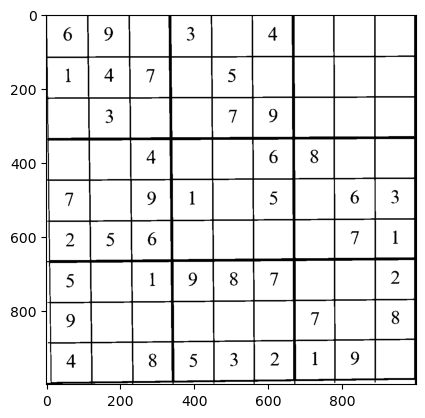

In [7]:
print(result.shape)
gray_result = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
thresh, binary_image = cv2.threshold(gray_result, 0, 255, cv2.THRESH_OTSU)
# 白い領域の平均値を計算
white_region = result.copy()
idx=binary_image!=0
mean_white = np.median(white_region[idx][2]), np.median(white_region[idx][1]), np.median(white_region[idx][0])
print(mean_white)
plt.imshow(binary_image, cmap="gray")
plt.imshow(binary_image!=0, cmap="gray")
# white

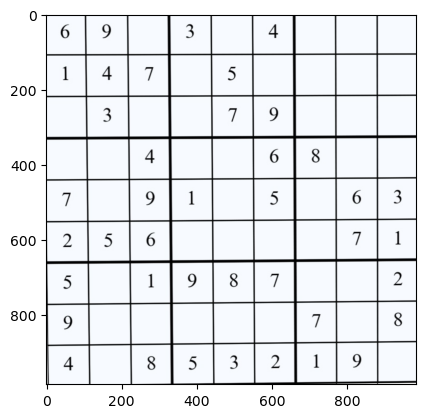

In [8]:
result = result
height, width, channels = result.shape[:3]
trim_percentage = 0.008  # 外側を.5%トリミング
trim_width = int(width * trim_percentage)
trim_height = int(height * trim_percentage)
result = result[trim_height:height - trim_height, trim_width:width - trim_width]
plt.imshow(result)

In [9]:
# # result=cv2.rotate(result,cv2.ROTATE_90_CLOCKWISE)
# gray=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
# # Threshold the image to create a binary image
# # Smooth the image
# gray = cv2.GaussianBlur(gray, (5, 5), 0)

# # Detect edges using Canny edge detection
# edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# # Detect lines using Hough line detection
# lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

# # Plot the detected lines on the image
# for line in lines:
#     rho, theta = line[0]
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a * rho
#     y0 = b * rho
#     x1 = int(x0 + 1000 * (-b))
#     y1 = int(y0 + 1000 * (a))
#     x2 = int(x0 - 1000 * (-b))
#     y2 = int(y0 - 1000 * (a))
#     cv2.line(result, (x1, y1), (x2, y2), (mean_white), 10)
# # h,w=result.shape[:2]
# # lines = cv2.HoughLinesP(
# #     edges, 
# #     rho=1, 
# #     theta=np.pi / 180, 
# #     threshold=60,  # 閾値を調整
# #     minLineLength=min(h/9,w/9)*0.55,  # 線分の最小長さを設定
# #     maxLineGap=18  # 同じ直線とみなす最大の間隔を設定
# # )
# # if lines is not None:
# #     for line in lines:
# #         x1, y1, x2, y2 = line[0]
# #         cv2.line(result, (x1, y1), (x2, y2), (mean_white), 20) 
# # Display the image with the detected lines
# plt.imshow(result, cmap="gray")
# plt.show()
# # Display the result

In [10]:
# # Load the image
# image = result

# # Define the size of the lines
# line_size = int(min(image.shape[:2]) / 9)

# # Define the spacing between the lines
# line_spacing = line_size
# print(line_size, line_spacing)
# # Create a copy of the image to draw the lines on
# result = image.copy()

# # Draw the vertical lines
# for x in range(line_size, image.shape[1], line_spacing):
#     cv2.line(result, (x, 0), (x, image.shape[0]), (mean_white), thickness=15)

# # Draw the horizontal lines
# for y in range(line_size, image.shape[0], line_spacing):
#     cv2.line(result, (0, y), (image.shape[1], y), (mean_white), thickness=15)

# # Display the image with the lines
# plt.imshow(result, cmap="gray")
# plt.show()
# result=result

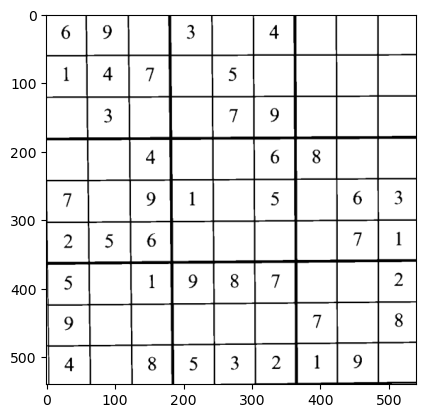

In [11]:
import cv2
import numpy as np
# scaler_f=pd.read_pickle("./pickle/knn_scaler_flip.pickle")
# clf_f=pd.read_pickle("./pickle/knn_clf_flip.pickle")

# scaler_f=pd.read_pickle("./pickle/rf_flip_scaler.pickle")
# clf_f=pd.read_pickle("./pickle/rf_clf_flip.pickle")

problems=[]
flip_proba=[]
# pixel=28
# scaler = pd.read_pickle('./pickle/svc_rbf_scaler.pickle')
# clf=pd.read_pickle('./pickle/svc_rbf_clf.pickle')
pixel=60
pkl_name="Rand_numbers_line_3"
scaler = pd.read_pickle(f'./pickle/{pkl_name}_scaler.pickle')
clf=pd.read_pickle(f'./pickle/{pkl_name}_clf.pickle')
# results=[result, cv2.rotate(result,cv2.ROTATE_90_CLOCKWISE), cv2.rotate(result,cv2.ROTATE_180), cv2.rotate(result,cv2.ROTATE_90_COUNTERCLOCKWISE)]
# for result in results:
# result: RGB
## get mean white

cropped = result.copy()
h,w,_=cropped.shape
cropped_rs=cv2.resize(cropped,(max(h,w),max(h,w)),interpolation=cv2.INTER_AREA)
cropped_gr=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY) # 白地


# plt.imshow(cropped_rs)
# plt.show()
# 内側の細い線を塗りつぶす
# closing
# cropped_cl = cv2.dilate(cropped_rs, np.ones((2, 2), dtype=edge.dtype),iterations=2)
# cropped_cl= cv2.erode(cropped_cl, np.ones((2, 2), dtype=edge.dtype),iterations=2)
# opening
cropped_cl = cv2.erode(cropped_rs, np.ones((2, 2), dtype=edge.dtype),iterations=2)
cropped_cl = cv2.dilate(cropped_cl, np.ones((2, 2), dtype=edge.dtype),iterations=2)
# plt.imshow(cropped_cl,cmap="gray")
# plt.show()

cropped_cl_gr=cv2.cvtColor(cropped_cl, cv2.COLOR_RGB2GRAY)
thr, binary = cv2.threshold(cropped_cl_gr, 0, 255, cv2.THRESH_OTSU)
# new_thr = min(int(thr * 1.3), 255)
# _, binary = cv2.threshold(cropped_region_gr, new_thr, 255, cv2.THRESH_BINARY)

binary=cv2.resize(binary,(pixel*9,pixel*9),interpolation=cv2.INTER_AREA)
# whether it is flipped or not
# digit=cv2.resize(binary,(1000,1000),interpolation=cv2.INTER_AREA)
# digit=digit.reshape(1,-1)
# digit=scaler_f.transform(digit)
# pred=clf_f.predict_proba(digit)
# print(pred,np.argmax(pred))
# flip_proba.append(pred[0][0])
# flag=np.argmax(pred)
# if flag:
plt.imshow(binary,cmap="gray")
plt.show()
# plot i,j th component
# i,j=0,3
# plt.imshow(binary[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel], cmap='gray')
# plt.show()

predicted_digits = []
for i in range(9):
    for j in range(9):
        digit_square = binary[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel]
        if np.mean(digit_square)>250:
            predicted_digits.append(0)
            continue
        digit_square = digit_square.reshape(1, -1)/255.0
        digit_square=scaler.transform(digit_square)
        prediction = clf.predict(digit_square)
        predicted_digit = np.argmax(prediction)
        predicted_digits.append(prediction[0])
problem=[]
for i in range(0, len(predicted_digits), 9):
    problem.append(predicted_digits[i:i+9])
    # print(predicted_digits[i:i+9])
# problems.append(problem)


In [12]:
# std_list=[]
# for problem in problems:
#     nonzeros=np.count_nonzero(problem)
#     num_cnt=np.bincount(np.array(problem).reshape(-1))
#     print(nonzeros,np.std(problem),np.mean(problem),np.sum(num_cnt[1:]**2))
#     std_list.append(np.std(problem))

In [13]:
# no_flip_idx=np.argmax(flip_proba)
# print(no_flip_idx)
# problem=problems[np.argmin(std_list)]
# problem=problems[0]
problem

[[6, 7, 0, 3, 0, 4, 0, 0, 0],
 [1, 4, 7, 0, 3, 0, 0, 0, 0],
 [0, 3, 0, 0, 7, 9, 0, 0, 0],
 [0, 0, 4, 0, 0, 6, 6, 0, 0],
 [7, 0, 9, 1, 0, 5, 0, 6, 3],
 [2, 5, 6, 0, 0, 0, 0, 7, 1],
 [5, 0, 1, 9, 6, 7, 0, 0, 2],
 [9, 0, 0, 0, 0, 0, 1, 0, 6],
 [4, 0, 8, 5, 3, 2, 1, 9, 0]]

In [14]:
with open(f'./data/{file}.txt', 'r') as f:
    matrix_data = [[int(num) for num in line.split()] for line in f]
# print matrix data by row
for row in matrix_data:
    print(row)
# convert the matrix data into a numpy array
matrix_array = np.array(matrix_data)
validate=[matrix_data[i][j]==problem[i][j] for i in range(9) for j in range(9)]
proba=sum(validate)/len(validate)
zeros=np.sum(np.array(matrix_data) == 0)
nonzeros=81-zeros
failed=81-proba*81
print(proba,failed,f"failure rate: {failed/nonzeros:.2f}")

[6, 9, 0, 3, 0, 4, 0, 0, 0]
[1, 4, 7, 0, 5, 0, 0, 0, 0]
[0, 3, 0, 0, 7, 9, 0, 0, 0]
[0, 0, 4, 0, 0, 6, 8, 0, 0]
[7, 0, 9, 1, 0, 5, 0, 6, 3]
[2, 5, 6, 0, 0, 0, 0, 7, 1]
[5, 0, 1, 9, 8, 7, 0, 0, 2]
[9, 0, 0, 0, 0, 0, 7, 0, 8]
[4, 0, 8, 5, 3, 2, 1, 9, 0]
0.9259259259259259 6.0 failure rate: 0.15


In [15]:
for i in range(9):
    print(validate[i*9:i*9+9])

[True, False, True, True, True, True, True, True, True]
[True, True, True, True, False, True, True, True, True]
[True, True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, False, True, True]
[True, True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True, True]
[True, True, True, True, False, True, True, True, True]
[True, True, True, True, True, True, False, True, False]
[True, True, True, True, True, True, True, True, True]
